In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

In [2]:
# Load the data that is in a .npy file

test = np.load('./data/ratings_test.npy')
train = np.load('./data/ratings_train.npy')

features = np.load('./data/namesngenre.npy')

# Create a dataframe with the data

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
df_features = pd.DataFrame(features)

# Check the data

#print(df_train.head())
#print(df_test.head())

# print the shape of the data

print(df_train.shape)


(610, 4980)


In [3]:
ratings_train = [0]*11
ratings_test = [0]*11

for col in df_train.columns:
    for i in range(len(df_train[col])):
        if not np.isnan(df_train[col][i]):
            ratings_train[int(df_train[col][i]*2)] += 1
        if not np.isnan(df_test[col][i]):
            ratings_test[int(df_test[col][i]*2)] += 1

Text(0.5, 1.0, 'General distribution of ratings for the testing data')

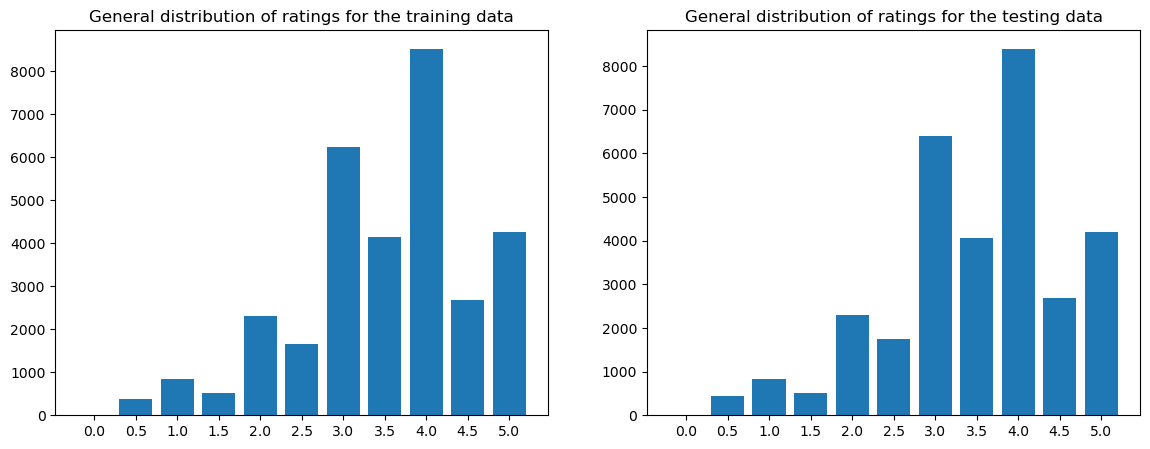

In [4]:
# plot a histogram of the ratings

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(11), ratings_train)
ax1.set_xticks(range(11), [x * 0.5 for x in range(11)])
ax1.set_title('General distribution of ratings for the training data')

ax2.bar(range(11), ratings_test)
ax2.set_xticks(range(11), [x * 0.5 for x in range(11)])
ax2.set_title('General distribution of ratings for the testing data')


In [5]:
print(df_features.tail())

print(features[:10])

                                              0                           1
4975                          Game Night (2018)  Action|Comedy|Crime|Horror
4976                   Making a Murderer (2015)           Crime|Documentary
4977                         Elsa & Fred (2005)        Comedy|Drama|Romance
4978                         Tomb Raider (2018)    Action|Adventure|Fantasy
4979  Fred Armisen: Standup for Drummers (2018)                      Comedy
[['Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy']
 ['Jumanji (1995)' 'Adventure|Children|Fantasy']
 ['Grumpier Old Men (1995)' 'Comedy|Romance']
 ['Waiting to Exhale (1995)' 'Comedy|Drama|Romance']
 ['Father of the Bride Part II (1995)' 'Comedy']
 ['Heat (1995)' 'Action|Crime|Thriller']
 ['Sabrina (1995)' 'Comedy|Romance']
 ['Tom and Huck (1995)' 'Adventure|Children']
 ['Sudden Death (1995)' 'Action']
 ['GoldenEye (1995)' 'Action|Adventure|Thriller']]


In [6]:
n_movies,p = df_features.shape
#print(n_movies,p)
all_genres = {}

# Create a dictionary with all the genres
for i in range(n_movies):
    genres = features[i][1]
    genres = genres.split('|')
    for genre in genres:
        if genre in all_genres.keys():
            all_genres[genre] += 1
        else :
            all_genres[genre] = 1
n_genre = len(all_genres)

genres_names = list(all_genres.keys())

features_year = np.empty((n_movies, p+n_genre), dtype=object)

for i in range(n_movies):
    title, genres = features[i]
    year = title[-5:-1]
    title = title[:-7]
    #genres = features[i][1]
    genres = genres.split('|')

    features_year[i][0] = title
    features_year[i][1] = year
    # 'one hot encoding' for the genres, could be more explicit than a one but the analyses will be easier this way
    for genre in genres:
        idx = genres_names.index(genre)
        features_year[i][2+idx] = 1

df_features = pd.DataFrame(features_year)

print(df_features.head())


# separate the year in the 1st column, create a list of the genres in the 2nd col


                            0     1     2     3     4     5     6     7   \
0                    Toy Story  1995     1     1     1     1     1  None   
1                      Jumanji  1995     1  None     1  None     1  None   
2             Grumpier Old Men  1995  None  None  None     1  None     1   
3            Waiting to Exhale  1995  None  None  None     1  None     1   
4  Father of the Bride Part II  1995  None  None  None     1  None  None   

     8     9   ...    12    13    14    15    16    17    18    19    20    21  
0  None  None  ...  None  None  None  None  None  None  None  None  None  None  
1  None  None  ...  None  None  None  None  None  None  None  None  None  None  
2  None  None  ...  None  None  None  None  None  None  None  None  None  None  
3     1  None  ...  None  None  None  None  None  None  None  None  None  None  
4  None  None  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 22 columns]


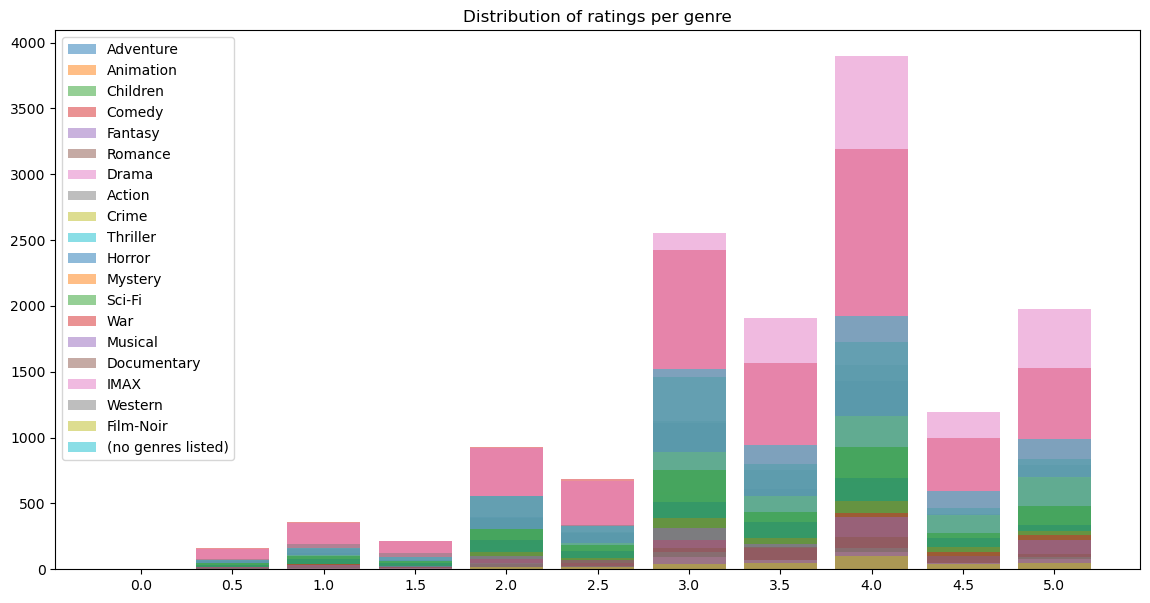

In [7]:
# distribution of the ratings per genre

ratings_genre = np.zeros((n_genre, 11))

for i in range(n_movies): # for each movie
    # for all the ratings this movie has
    score = df_train[:][i].dropna()
    score = list(score)
    
    # for each genre of the movie, increment the ratings_genre array with regards to score
    for j in range(n_genre):
        if df_features[2+j][i] is not None:
            for k in range(len(score)):
                ratings_genre[j,int(score[k]*2)] += 1
    
# for each genre, plot the distribution of the ratings
# TODO: would be better to have a stacked bar plot

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for i in range(n_genre):
    ax.bar(range(11), ratings_genre[i], alpha=0.5)

ax.set_xticks(range(11), [x * 0.5 for x in range(11)])
ax.set_title('Distribution of ratings per genre')
ax.legend(genres_names)

plt.show()


The most popular 5 genres are:
Drama with 0.18316831683168316% ratings
Comedy with 0.15955419071318896% ratings
Thriller with 0.09506538889183036% ratings
Action with 0.08707047175305765% ratings
Romance with 0.07424418912479483% ratings


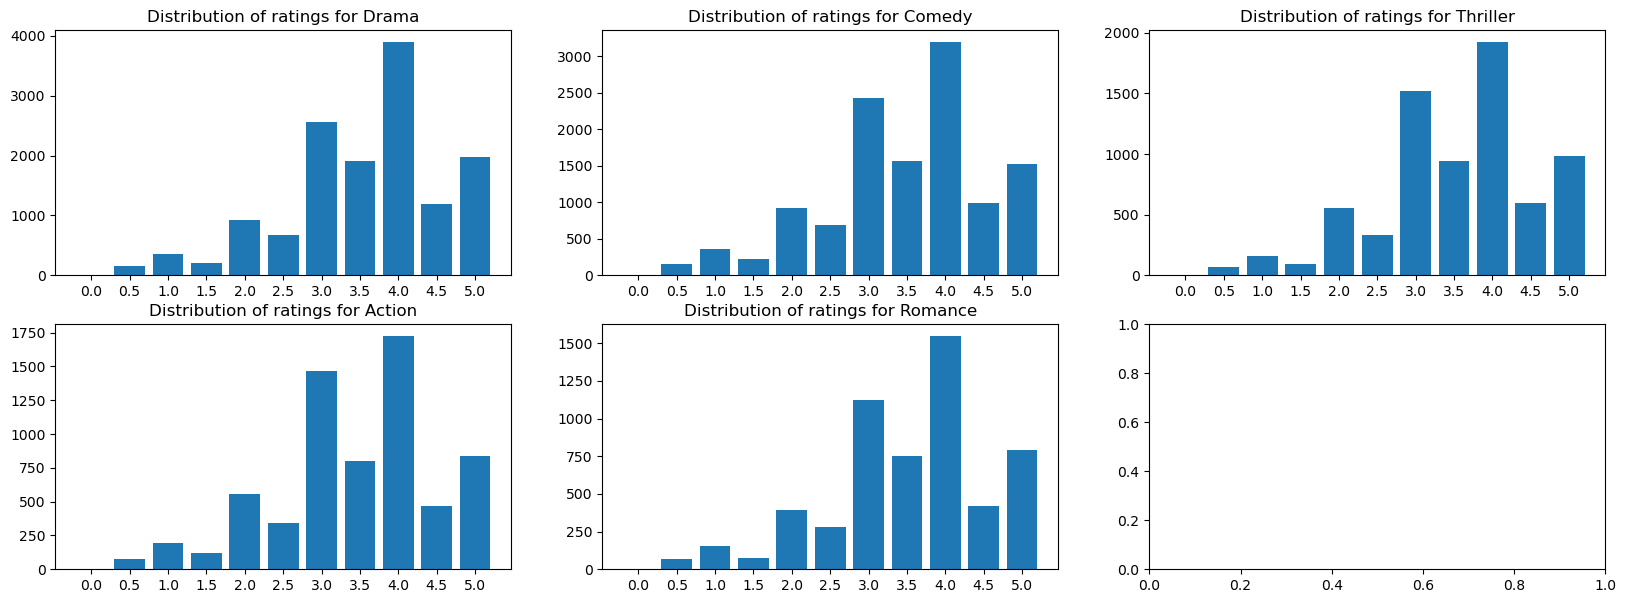

In [8]:
n_ratings_per_genre = np.sum(ratings_genre, axis=1)

idx = np.argsort(n_ratings_per_genre)

# total number of ratings 
total_ratings = np.sum(n_ratings_per_genre)


print('The most popular 5 genres are:')
fig, axs = plt.subplots(2,3, figsize=(20, 7))
for i in range(1,6):
    print(genres_names[idx[-i]]+' with '+str(n_ratings_per_genre[idx[-i]]/total_ratings)+'%'+' ratings')
    # for each of them, plot the distribution of the ratings
    k = (i-1)//3
    l = (i-1)%3

    axs[k,l].bar(range(11), ratings_genre[idx[-i]])
    axs[k,l].set_xticks(range(11), [x * 0.5 for x in range(11)])
    axs[k,l].set_title('Distribution of ratings for '+genres_names[idx[-i]])
plt.show()



/tmp/ipykernel_10478/2838791013.py:23: RuntimeWarning: invalid value encountered in divide
  ratings_percentage = ratings_length / ratings_length.sum(axis=1, keepdims=True) * 100


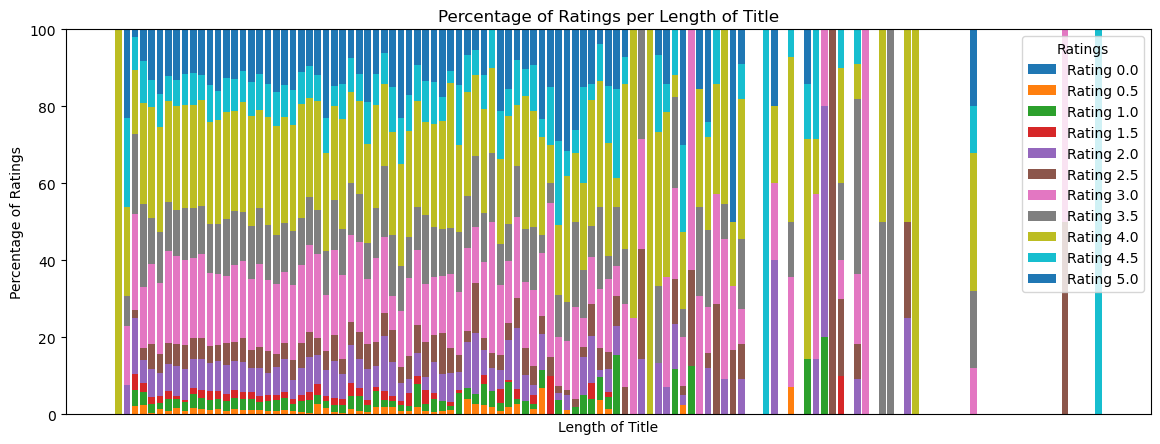

In [9]:
# count the length of the title of the movies and see if it has an impact on the ratings

# plot the median of the ratings per length of the title

length_title = np.zeros(n_movies)

for i in range(n_movies):
    length_title[i] = len(df_features[0][i])

df_features['length_title'] = length_title

max_length = int(np.max(length_title))

ratings_length = np.zeros((max_length+1, 11))

for i in range(n_movies):
    score = df_train[:][i].dropna()
    score = list(score)
    for j in range(len(score)):
        ratings_length[int(length_title[i]),int(score[j]*2)] += 1

# Calculate the percentage of ratings for each length of the title
ratings_percentage = ratings_length / ratings_length.sum(axis=1, keepdims=True) * 100

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Plot stacked bar chart
for i in range(11):
    ax.bar(range(max_length + 1), ratings_percentage[:, i], bottom=np.sum(ratings_percentage[:, :i], axis=1), label=f'Rating {i / 2:.1f}')

# Set x-axis labels
ax.set_xticks(range(max_length + 1, 5))
ax.set_xticklabels(range(max_length + 1, 5))
ax.set_xlabel('Length of Title')
ax.set_ylabel('Percentage of Ratings')
ax.set_title('Percentage of Ratings per Length of Title')
ax.legend(title='Ratings')

plt.show()

# plot stacked bar of the ratings per length of the title, set x ticks to be the length of the title


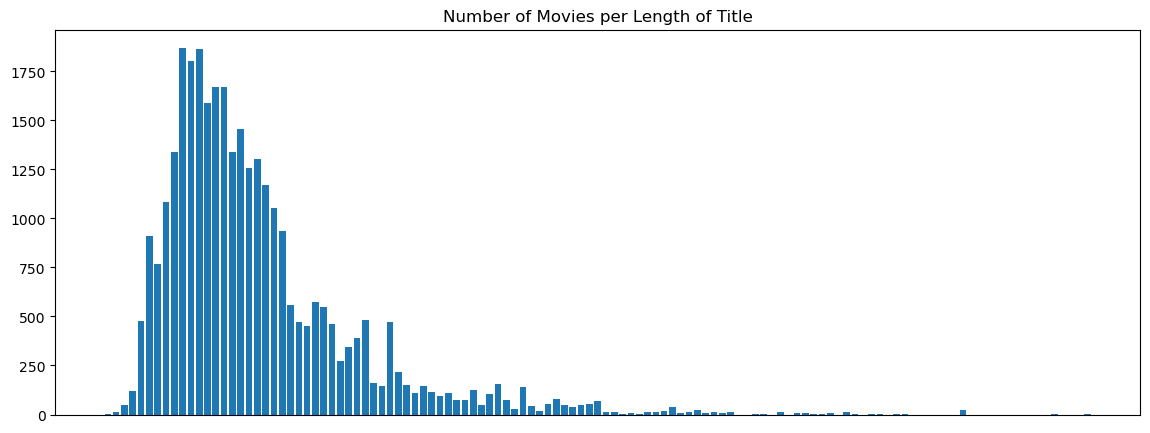

/tmp/ipykernel_10478/2510578355.py:21: RuntimeWarning: invalid value encountered in divide
  filtered_ratings_percentage = filtered_ratings_length / filtered_ratings_length.sum(axis=1, keepdims=True) * 100


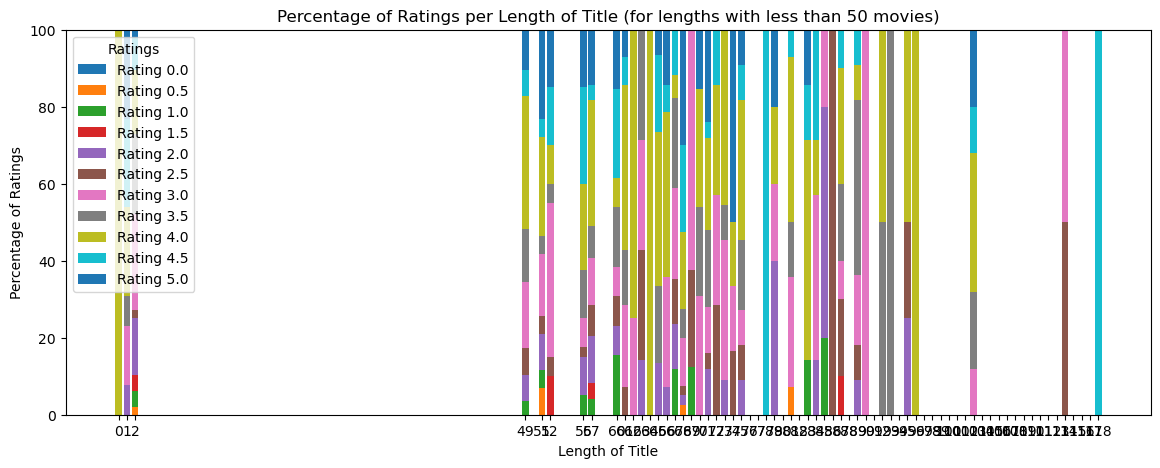

The lengths of title with less than 50 movies are:
[  0   1   2  49  51  52  56  57  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118]


In [10]:
# plot number of movies per length

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.bar(range(max_length + 1), np.sum(ratings_length, axis=1))
ax.set_xticks(range(max_length + 1, 5))
ax.set_xticklabels(range(max_length + 1, 5))
ax.set_title('Number of Movies per Length of Title')

plt.show()

# keep only the length that have less than 200 movies

# Calculate the number of movies per length of title
num_movies_per_length = np.sum(ratings_length, axis=1)

# Filter lengths that have less than 200 movies
filtered_lengths = np.where(num_movies_per_length < 50)[0]

filtered_ratings_length = ratings_length[filtered_lengths]
filtered_ratings_percentage = filtered_ratings_length / filtered_ratings_length.sum(axis=1, keepdims=True) * 100

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Plot stacked bar chart
for i in range(11):
    ax.bar(filtered_lengths, filtered_ratings_percentage[:, i], bottom=np.sum(filtered_ratings_percentage[:, :i], axis=1), label=f'Rating {i / 2:.1f}')

# Set x-axis labels
ax.set_xticks(filtered_lengths)
ax.set_xticklabels(filtered_lengths)
ax.set_xlabel('Length of Title')
ax.set_ylabel('Percentage of Ratings')
ax.set_title('Percentage of Ratings per Length of Title (for lengths with less than 50 movies)')
ax.legend(title='Ratings')

plt.show()

print('The lengths of title with less than 50 movies are:')
print(filtered_lengths)

In [11]:
print('the title of the movies with less than 50 movies are:')
for i in filtered_lengths:
    print(df_features[0][i], 'with length equal to', length_title[i])


the title of the movies with less than 50 movies are:
Toy Story with length equal to 9.0
Jumanji with length equal to 7.0
Grumpier Old Men with length equal to 16.0
Indian in the Cupboard, The with length equal to 27.0
Mr. Holland's Opus with length equal to 18.0
Don't Be a Menace to South Central While Drinking Your Juice in the Hood with length equal to 72.0
French Twist (Gazon maudit) with length equal to 27.0
Friday with length equal to 6.0
Kicking and Screaming with length equal to 21.0
Misérables, Les with length equal to 15.0
Bed of Roses with length equal to 12.0
Big Bully with length equal to 9.0
Screamers with length equal to 9.0
Crossing Guard, The with length equal to 19.0
Juror, The with length equal to 10.0
Things to Do in Denver When You're Dead with length equal to 39.0
Antonia's Line (Antonia) with length equal to 24.0
Angels and Insects with length equal to 18.0
White Squall with length equal to 12.0
Dunston Checks In with length equal to 17.0
Black Sheep with length 

In [12]:
import numpy as np
#print indices in the ratings table of rating equal to 0

ratings_0 = np.where(df_train == 0)[0]

print('The indices of the ratings table where the rating is equal to 0 are:')


The indices of the ratings table where the rating is equal to 0 are:


Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90


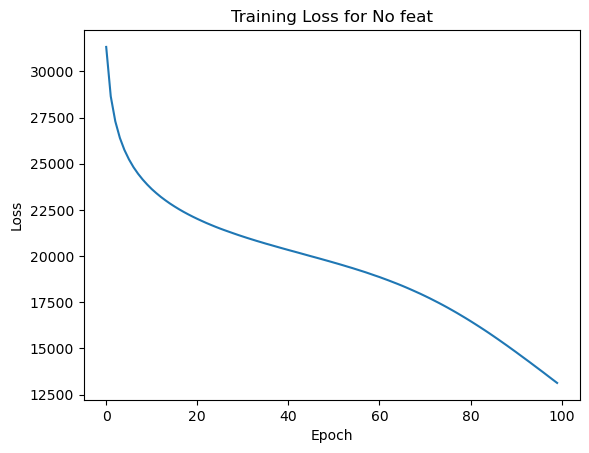

Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90


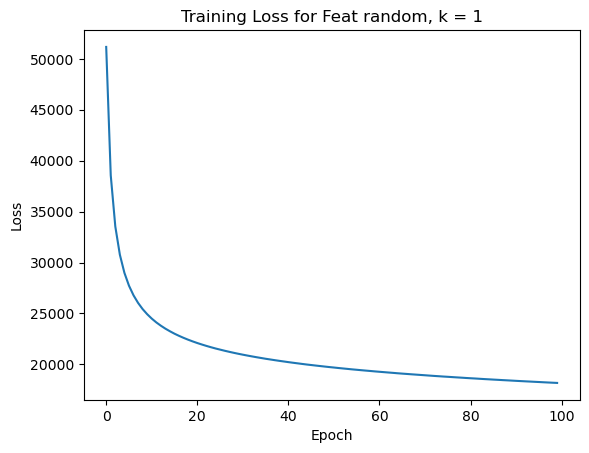

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [3]:

import argparse
import numpy as np
from feat_processing import load_sep_feat
import matplotlib.pyplot as plt

# Open Ratings table
table = np.load('./data/ratings_train.npy') ## DO NOT CHANGE THIS LINE

# Data preprocessing
table = np.nan_to_num(table)

# Load features

add_features = load_sep_feat('./data/namesngenre.npy')

# TODO : think of an optimized way to learn the features in the latent space then map them
# en vrai instead of learning for each one, learn for the few existing distinct ones
# then put them together once the training is done
# I think that's not how the paper does it but it's sth to consider ?

# Model definition
class Model:
    def __init__(self, parameters, feat = True, init_feat = 'random', k = 0):

        self.parameters = parameters
        self.feat = feat

        if k == 0:
            k = self.parameters['features']

        self.nb_users, self.nb_movies = self.parameters['Dataset'].shape

        # this will be filled if feat is True
        self.F = np.zeros((self.nb_movies,k))
        
        if self.feat:
            self.table_feat = self.parameters['add_features'][0]
            self.all_feat = self.parameters['add_features'][1:] # here it's just all_years and all_genres
            self.nbs_feat = [len(i) for i in self.all_feat] # |Ft| the number of possibility for each feature

            # init to random or init to 0?
            # to be changed if it goes weird
            # Y the latent factor representation of the features
            self.Y = []
            for t in range(len(self.all_feat)):
                # for each feature, we create a matrix of size |Ft| x k
                if init_feat == 'zero' :
                    self.Y.append(np.zeros((self.nbs_feat[t], k)))
                else: # random by default
                    self.Y.append(np.random.normal(scale=1. / k, size=(self.nbs_feat[t], k)))

        # Take all the non zero values of the dataset and separate the row and column indices
        self.sample_row, self.sample_col = self.parameters['Dataset'].nonzero()
        self.U_bias, self.I_bias = np.zeros(self.nb_users), np.zeros(self.nb_movies)

        self.global_bias = np.mean(self.parameters['Dataset'][np.where(self.parameters['Dataset'] != 0)])

        self.U, self.I = (np.random.normal(scale=1. / k, size=(self.nb_users, k)),
                          np.random.normal(scale=1. / k, size=(self.nb_movies, k)))
            
        self.train_loss = np.zeros(self.parameters['epoch'])
        
    def train(self):
        c = 0
        while c < self.parameters['epoch']:
            if c % 10 == 0:
                print("Epoch: ", c)
            training_indices = np.arange(len(self.sample_row))
            np.random.shuffle(training_indices)

            for u, i in zip(self.sample_row[training_indices], self.sample_col[training_indices]):

                if self.feat:
                    # Compute the 'item' term including the features                
                    for t in range(len(self.all_feat)):
                        for a in range(self.nbs_feat[t]):
                            self.F[i] += self.Y[t][a] 
                        self.F[i] = self.F[i] / self.nbs_feat[t]

                pred = self.U[u].dot(self.I[i] + self.F[i]) + self.global_bias + self.U_bias[u] + self.I_bias[i]
                e = self.parameters['Dataset'][u, i] - pred

                # keep the training and validation loss
                self.train_loss[c] += e ** 2                

                self.U_bias[u] += self.parameters['learning_rate'] * (e - self.parameters['regulation'] * self.U_bias[u])
                self.I_bias[i] += self.parameters['learning_rate'] * (e - self.parameters['regulation'] * self.I_bias[i])

                self.U[u] += self.parameters['learning_rate'] * (e * (self.I[i] + self.F[i]) - self.parameters['regulation']* self.U[u])
                self.I[i] += self.parameters['learning_rate'] * (e * self.U[u] - self.parameters['regulation'] * self.I[i])

                if self.feat:
                    for t in range(len(self.all_feat)):
                        for a in range(self.nbs_feat[t]):
                            self.Y[t][a] += self.parameters['learning_rate'] * (e * self.U[u] / self.nbs_feat[t] - self.parameters['regulation'] * self.Y[t][a])

            c += 1

        biases = self.global_bias + self.U_bias[:, np.newaxis] + self.I_bias[np.newaxis, :]
        predictions = self.U.dot((self.I + self.F).T) + biases

        return np.nan_to_num(predictions)


# Hyper Parameters Definition
Parameters = {'Dataset': table,
              'features': 60,
              'add_features': add_features,
              'regulation': 0.04,
              'epoch': 100,
              'learning_rate': 0.0035}

# Model Training
#MyModel = Model(Parameters)
#result = MyModel.train()

# Post Process
#result = np.clip(result, 0.5, 5)

def eval_model(result, title):
    test = np.load("./data/ratings_test.npy")
    test = np.nan_to_num(test)

    rmse = np.sqrt(np.mean((test - result) ** 2))
    accuracy = np.mean(np.round(result) == test)

    # plot the training loss
    plt.plot(MyModel.train_loss)
    plt.title('Training Loss for '+ title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return rmse, accuracy

# np.save("output.npy", result)

# test for no features, for features random, for features init zero, for features zero / random and k in [1 - 10, - 60]

# on veut tester
list_k = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60]
titles = [] 
rmse, accuracy = [], []

for tests in range(len(list_k)+1):
    if tests == 0:
        title = 'No feat'
        MyModel = Model(Parameters, feat= False)
        result = MyModel.train()
        r,a = eval_model(result, title)
        rmse.append(r)
        accuracy.append(a)
        titles.append(title)
    else:
        k = list_k[tests]

        title = 'Feat '+'random, k = '+ str(k)
        MyModel = Model(Parameters, init_feat = 'random', k = k)
        result = MyModel.train()
        r,a = eval_model(result, title)
        rmse.append(r)
        accuracy.append(a)
        titles.append(title)

        title = 'Feat '+'zero, k = '+ str(k)
        MyModel = Model(Parameters, init_feat = 'zero', k = k)
        result = MyModel.train()
        r,a = eval_model(result, title)
        rmse.append(r)
        accuracy.append(a)
        titles.append(title)

    np.save("rmse.npy", [tests]+rmse)
    np.save("accuracy.npy", [tests]+accuracy)
    np.save("titles.npy", [tests]+titles)
